In [3]:
import pandas as pd
import numpy as np
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
data = pd.read_csv('news.csv')

In [29]:
# Establish a connection to the SQLite database
conn = sqlite3.connect('news.db')
data.to_sql('news', conn, if_exists='replace', index=False)

6335

In [33]:
# Read data from the SQL database
data = pd.read_sql_query('SELECT * FROM news_data', conn)

In [34]:
# Data preprocessing
data['label'] = data['label'].map({'FAKE': 0, 'REAL': 1})

In [35]:
# Data cleansing
def clean_text(text):
    # Remove unwanted characters, numbers, and symbols
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords and perform lemmatization
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

In [27]:
data['text'] = data['text'].apply(clean_text)

LookupError: 
**********************************************************************
  Resource [93momw-1.4[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('omw-1.4')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/omw-1.4[0m

  Searched in:
    - 'C:\\Users\\Owner/nltk_data'
    - 'C:\\Users\\Owner\\anaconda\\anaconda3\\nltk_data'
    - 'C:\\Users\\Owner\\anaconda\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\Owner\\anaconda\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Owner\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

In [12]:
# Feature extraction using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [13]:
# Train the model using Logistic Regression
log_reg = LogisticRegression(verbose=1)
log_reg.fit(tfidf_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


LogisticRegression(verbose=1)

In [14]:
# Model evaluation
y_pred = log_reg.predict(tfidf_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [15]:
print("Model Accuracy: {:.2f}".format(accuracy * 100))
print("\nClassification Report:\n", report)

Model Accuracy: 91.55

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92       628
           1       0.93      0.90      0.91       639

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



([<matplotlib.axis.YTick at 0x267b57718e0>,
 [Text(0, 0, 'FAKE'), Text(0, 1, 'REAL')])

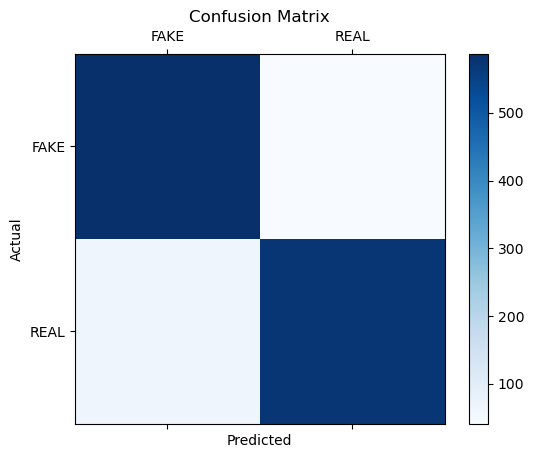

In [16]:
# Visualize the confusion matrix using Matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(confusion_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['FAKE', 'REAL'])
plt.yticks([0, 1], ['FAKE', 'REAL'])

In [17]:
# Display values in the confusion matrix
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(j, i, str(confusion_mat[i, j]), va='center', ha='center', color='red', fontsize=14)

plt.show()

In [18]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

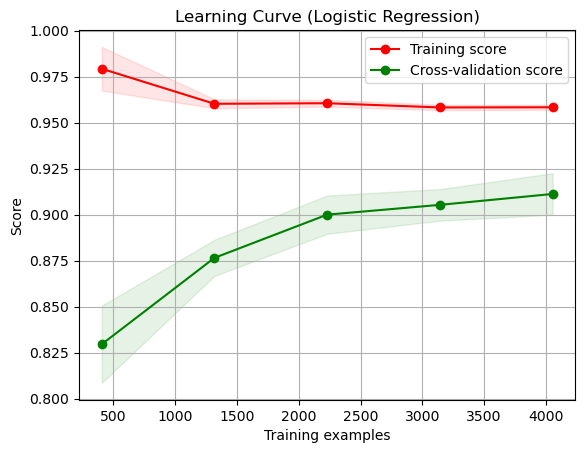

In [19]:
# Plot the learning curve for the Logistic Regression model
plot_learning_curve(log_reg, "Learning Curve (Logistic Regression)", tfidf_train, y_train, cv=5)
plt.show()

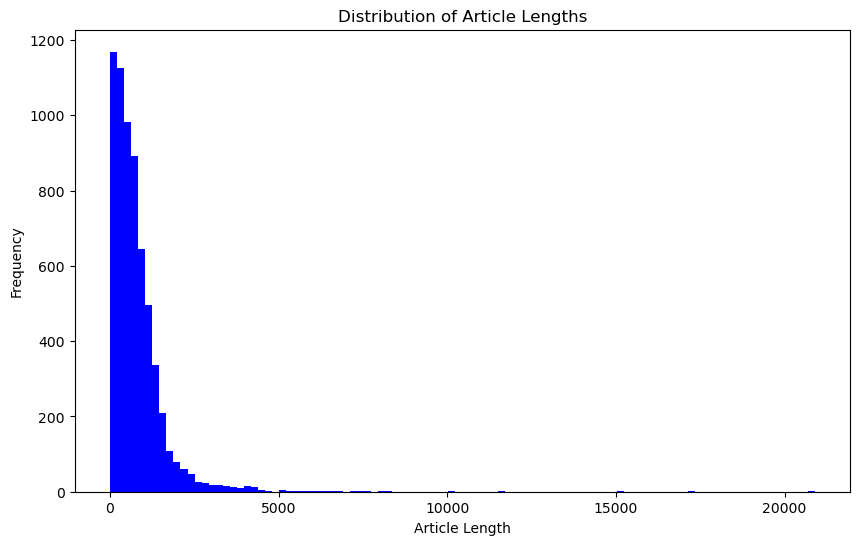

In [36]:
article_lengths = data['text'].apply(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(article_lengths, bins=100, color='blue')

ax.set_xlabel('Article Length')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Article Lengths')

plt.savefig("histogram.jpeg")

# plt.show()


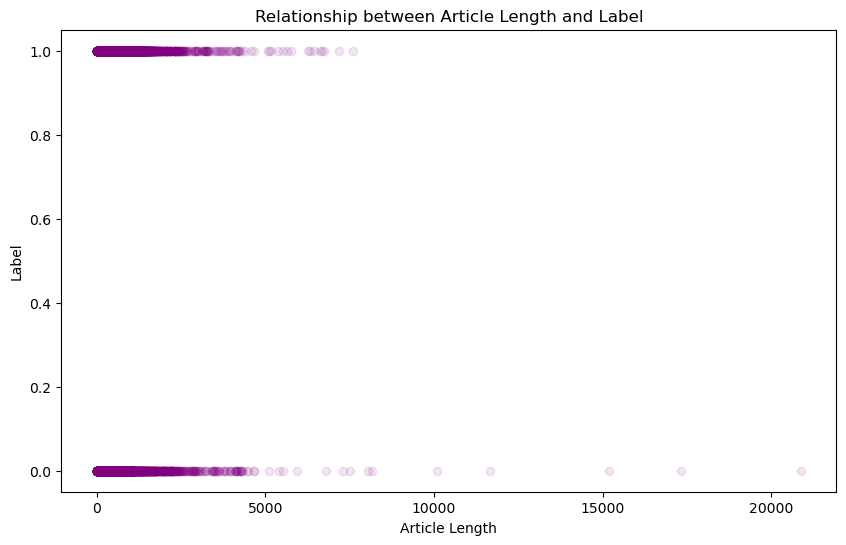

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(article_lengths, data['label'], alpha=0.1, color='purple')

ax.set_xlabel('Article Length')
ax.set_ylabel('Label')
ax.set_title('Relationship between Article Length and Label')

plt.savefig("scatter_plot.jpeg")

# plt.show()